In [ ]:
# !pip install pyts
# !pip install tensorflow
# !pip install numpy
# !pip install pandas

In [ ]:
#################
### Libraries ###
#################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#################
###   Data    ###
#################

bitcoin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC_noscale.csv')
bitcoin.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
bitcoin.head()

,Date,Close
0,2018-01-01,13535.0
1,2018-01-02,14770.0
2,2018-01-03,15057.0
3,2018-01-04,14921.0
4,2018-01-05,16828.0


In [ ]:
########################
#### Input GAF/MTF  ####
########################

btc = bitcoin.iloc[:]

# ------------
# Parameters
# ------------
window_size = 224     # timesteps per sample
image_size = 224      # size for GAF/MTF images
train_ratio = 0.75    # training ratio


# ----------------------
# Step 1 — Normalization
# ----------------------
scaler = MinMaxScaler(feature_range=(0, 1))
btc['close_scaled'] = scaler.fit_transform(btc[['Close']])

# ---------------------------------
# Step 2 — Generate sliding windows
# ---------------------------------
def create_sequences(series, window_size):
    X_seq = []
    y = []
    for i in range(len(series) - window_size):
        X_seq.append(series[i:i+window_size])
        y.append(series[i+window_size])  # predict next value
    return np.array(X_seq), np.array(y)

X_seq, y = create_sequences(btc['close_scaled'].values, window_size)

# ---------------------------------
# Step 3 — GAF & MTF for CNN branch
# ---------------------------------
gasf = GramianAngularField(image_size=image_size, method='summation')
gadf = GramianAngularField(image_size=image_size, method='difference')
mtf = MarkovTransitionField(image_size=image_size)

# Apply transforms to each sequence
X_gasf = gasf.fit_transform(X_seq)
X_gadf = gadf.fit_transform(X_seq)
X_mtf = mtf.fit_transform(X_seq)

# Stack into channels: (samples, H, W, 3)
X_cnn = np.stack((X_gasf, X_gadf, X_mtf), axis=-1)

In [ ]:
# -------------------------------
# Step 5 — Train/Test split
# -------------------------------
n_samples = len(X_seq)
train_end = int(n_samples * train_ratio)

X_cnn_train, X_cnn_test = X_cnn[:train_end], X_cnn[train_end:]
y_train, y_test = y[:train_end], y[train_end:]

# -------------------
# Shapes check
# -------------------
print("CNN train shape:", X_cnn_train.shape)   # (samples, H, W, 3)
print("Targets train shape:", y_train.shape)

CNN train shape: (1314, 224, 224, 3)
Targets train shape: (1314,)


In [ ]:
################
##### CNN  #####
################

# ------------------------
# Step 1 — Build Input CNN
# ------------------------
cnn_input = Input(shape=(224, 224, 3))
dropout_rate = 0.29145153405423596
activation_func = 'relu'

# --------------------------------------------
# Step 2 — Build VGG16 Model (pre-trained CNN)
# --------------------------------------------

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)


# ----------------------------------
# Step 3 — Convolution/Pooling/Dense
# ----------------------------------

# Conv2D 64-10, Flatten, Dense(200)
x = vgg(cnn_input)
x = layers.Conv2D(128, (2, 2), activation=activation_func)(x)
x = layers.Conv2D(64, (2, 2), activation=activation_func)(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(128, activation=activation_func)(x)

# ---------------------------
# Step 6 — Concated O/P
# ---------------------------
output = Dense(1, activation='linear')(x)

# ----------------------------------
# Step 7 — Compile Model/Regression
# ----------------------------------
optimizer_func = RMSprop(learning_rate=0.0004047368844376192)
model = Model(inputs=cnn_input, outputs=output)
model.compile(loss='mean_squared_error', optimizer=optimizer_func, metrics=['mae', RootMeanSquaredError(), 'mape'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# --------------------
# Step 8 — Training
# --------------------

history = model.fit(X_cnn_train, y_train,
                   epochs=150, batch_size=64,
                   verbose=2)

Epoch 1/150
21/21 - 47s - 2s/step - loss: 1341.5283 - mae: 8.3685 - mape: 216965.2656 - root_mean_squared_error: 36.6269
Epoch 2/150
21/21 - 2s - 111ms/step - loss: 0.0854 - mae: 0.2412 - mape: 186066.5938 - root_mean_squared_error: 0.2922
Epoch 3/150
21/21 - 2s - 110ms/step - loss: 0.0813 - mae: 0.2344 - mape: 133088.1719 - root_mean_squared_error: 0.2852
Epoch 4/150
21/21 - 2s - 110ms/step - loss: 0.0705 - mae: 0.2115 - mape: 29499.8691 - root_mean_squared_error: 0.2655
Epoch 5/150
21/21 - 2s - 110ms/step - loss: 0.0628 - mae: 0.1894 - mape: 67854.3516 - root_mean_squared_error: 0.2507
Epoch 6/150
21/21 - 2s - 110ms/step - loss: 0.0312 - mae: 0.1332 - mape: 21906.7324 - root_mean_squared_error: 0.1765
Epoch 7/150
21/21 - 2s - 110ms/step - loss: 0.0660 - mae: 0.1840 - mape: 91817.5469 - root_mean_squared_error: 0.2568
Epoch 8/150
21/21 - 2s - 110ms/step - loss: 0.0432 - mae: 0.1511 - mape: 96156.4844 - root_mean_squared_error: 0.2078
Epoch 9/150
21/21 - 2s - 110ms/step - loss: 0.0146 

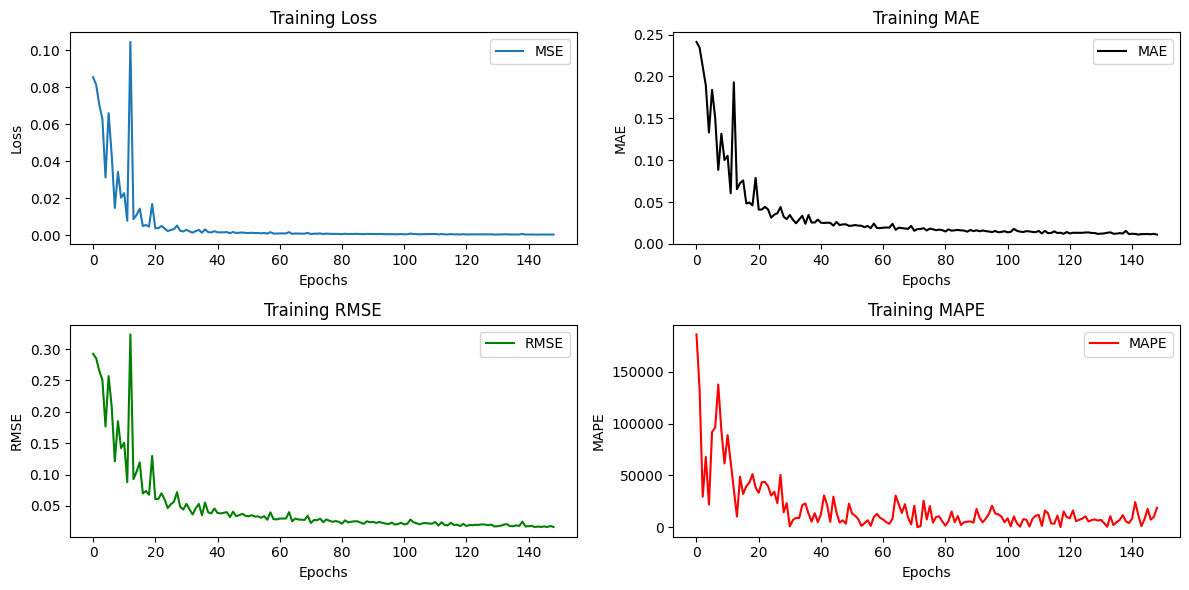

In [ ]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'][1:], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

# Training MAE
ax[0, 1].plot(history.history['mae'][1:], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()

# Training RMSE
ax[1, 0].plot(history.history['root_mean_squared_error'][1:], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()

# Training MAPE
ax[1, 1].plot(history.history['mape'][1:], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#####################
## Predict/Testing ##
#####################

y_predict= model.predict(X_cnn_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step


In [ ]:
y_predict[0:50]

array([[0.5489641 ],
       [0.5207586 ],
       [0.49152958],
       [0.4849635 ],
       [0.47513705],
       [0.5008565 ],
       [0.5066559 ],
       [0.50484324],
       [0.4782297 ],
       [0.46675122],
       [0.43014804],
       [0.41701323],
       [0.40460083],
       [0.41547626],
       [0.41863102],
       [0.42455414],
       [0.39667314],
       [0.35729286],
       [0.32488534],
       [0.31541565],
       [0.29298216],
       [0.29854682],
       [0.30062395],
       [0.30615774],
       [0.275358  ],
       [0.25500354],
       [0.26402915],
       [0.27696332],
       [0.28313985],
       [0.2977653 ],
       [0.31604886],
       [0.3087301 ],
       [0.28108844],
       [0.23023337],
       [0.238956  ],
       [0.19722244],
       [0.19057874],
       [0.16372338],
       [0.19229636],
       [0.14282757],
       [0.13556197],
       [0.13311213],
       [0.15542161],
       [0.1549969 ],
       [0.14738448],
       [0.14901122],
       [0.15291667],
       [0.162

In [ ]:
y_test.shape

(439,)

In [ ]:
# Test MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_predict)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.044873423000709345


In [ ]:
#--------------------------------------
# Inverse scaling: original price scale
#--------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

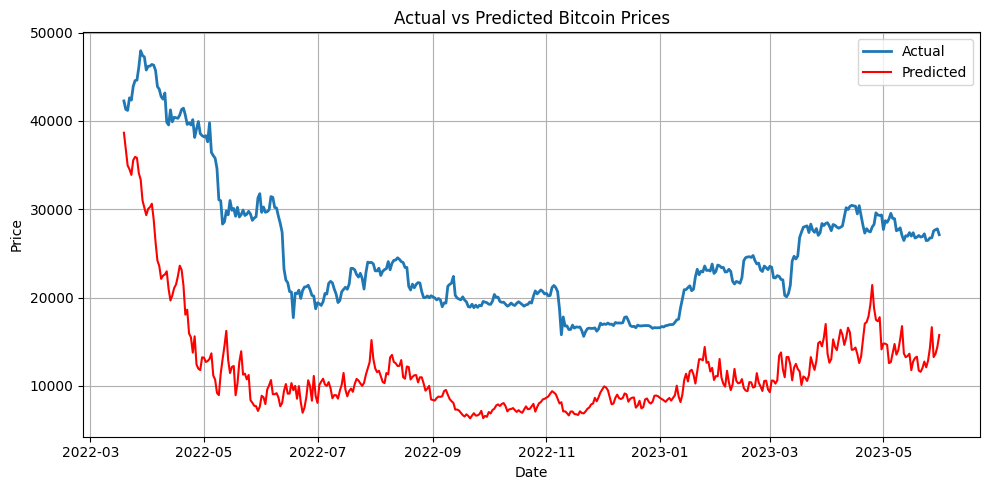

In [ ]:
#-----------------------------
# Plot prediction vs. actuals
#-----------------------------

start_index = len(y_train)+ 224

dates = btc['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)

# Convert to datetime if not already
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Export results

loss_results = pd.DataFrame(history.history)
loss_results.to_csv('loss_results.csv')

from google.colab import files
files.download('loss_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>